In [2]:
import pandas as pd
import numpy as np
import sqlite3

import warnings
warnings.filterwarnings("ignore")

import mysql.connector

# Connect to MySQL
conn = mysql.connector.connect(
    host="xxxxxxxxxx",        # your MySQL host, usually 'localhost'
    user="xxxxxxxxxx",             # your MySQL username
    password="xxxxxxxxxxx",# your MySQL password
    database=xxxxxx  # the database you want to use
)

cursor = conn.cursor()

try:
    # This SQL command modifies the session's sql_mode
    conn.cursor().execute("SET SESSION sql_mode=(SELECT REPLACE(@@sql_mode,'ONLY_FULL_GROUP_BY',''));")
    print("ONLY_FULL_GROUP_BY has been temporarily disabled for this session.")
except Exception as e:
    print(f"Error setting SQL mode: {e}")

tables = pd.read_sql_query('SHOW TABLES',conn)
tables

ONLY_FULL_GROUP_BY has been temporarily disabled for this session.


,Tables_in_inventory
0,begin_inventory
1,end_inventory
2,purchase_prices
3,purchases
4,sales
5,vendor_invoice
6,vendor_sales_summary


<!-- 
    NOTE: This HTML provides a concise, single-line status banner. 
    It is designed to be copied directly into a Jupyter Notebook's Markdown cell.
-->
<div style="
    padding: 8px 15px; 
    background-color: #e9f0f8; 
    border-left: 4px solid #0056b3; 
    border-radius: 4px; 
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    color: #004085;
    font-size: 0.95em;
    display: flex;
    align-items: center;
">
    <span style="font-weight: 700; margin-right: 10px;">SECURITY NOTE:</span> 
    All sensitive database connection information has been <strong> *censored* </strong> from the committed files.
</div>


In [3]:
df = pd.read_sql_query('select * from vendor_sales_summary',conn)

<h2>Exploratory Data Analysis</h2>

<ul>
    <li>Previously, we examined the various tables in the database to <b>identify key variables, understand their relationships, and determine which ones should be included in the final analysis.</b></li>
    <li>In this phase of EDA, we will <b>analyze the resultant table to gain insights into the distribution of each column.</b> This will help us <b>understand data patterns, identify anomalies, and ensure data quality</b> before proceeding with further analysis.</li>
</ul>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sqlite3
from scipy.stats import ttest_ind
import scipy.stats as stats
warnings.filterwarnings('ignore')

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorNumber,10692.0,10650.649458,18753.519148,2.00,3951.0000,7153.000,9552.0000,201359.00
Brand,10692.0,18039.228769,12662.187074,58.00,5793.5000,18761.500,25514.2500,90631.00
PurchasePrice,10692.0,24.385303,109.269375,0.36,6.8400,10.455,19.4825,5681.81
ActualPrice,10692.0,35.643671,148.246016,0.49,10.9900,15.990,28.9900,7499.99
Volume,10692.0,847.360643,664.309116,50.00,750.0000,750.000,750.0000,20000.00
TotalPurchaseQuantity,10692.0,3140.886831,11095.086769,1.00,36.0000,262.000,1975.7500,337660.00
TotalPurchaseDollars,10692.0,30106.693372,123067.799627,0.71,453.4575,3655.465,20738.2450,3811251.60
TotalSalesQuantity,10692.0,3077.482136,10952.851391,0.00,33.0000,261.000,1929.2500,334939.00
TotalSalesDollars,10692.0,42239.074419,167655.265984,0.00,729.2200,5298.045,28396.9150,5101919.51
TotalSalesPrice,10692.0,18793.783627,44952.773386,0.00,289.7100,2857.800,16059.5625,672819.31


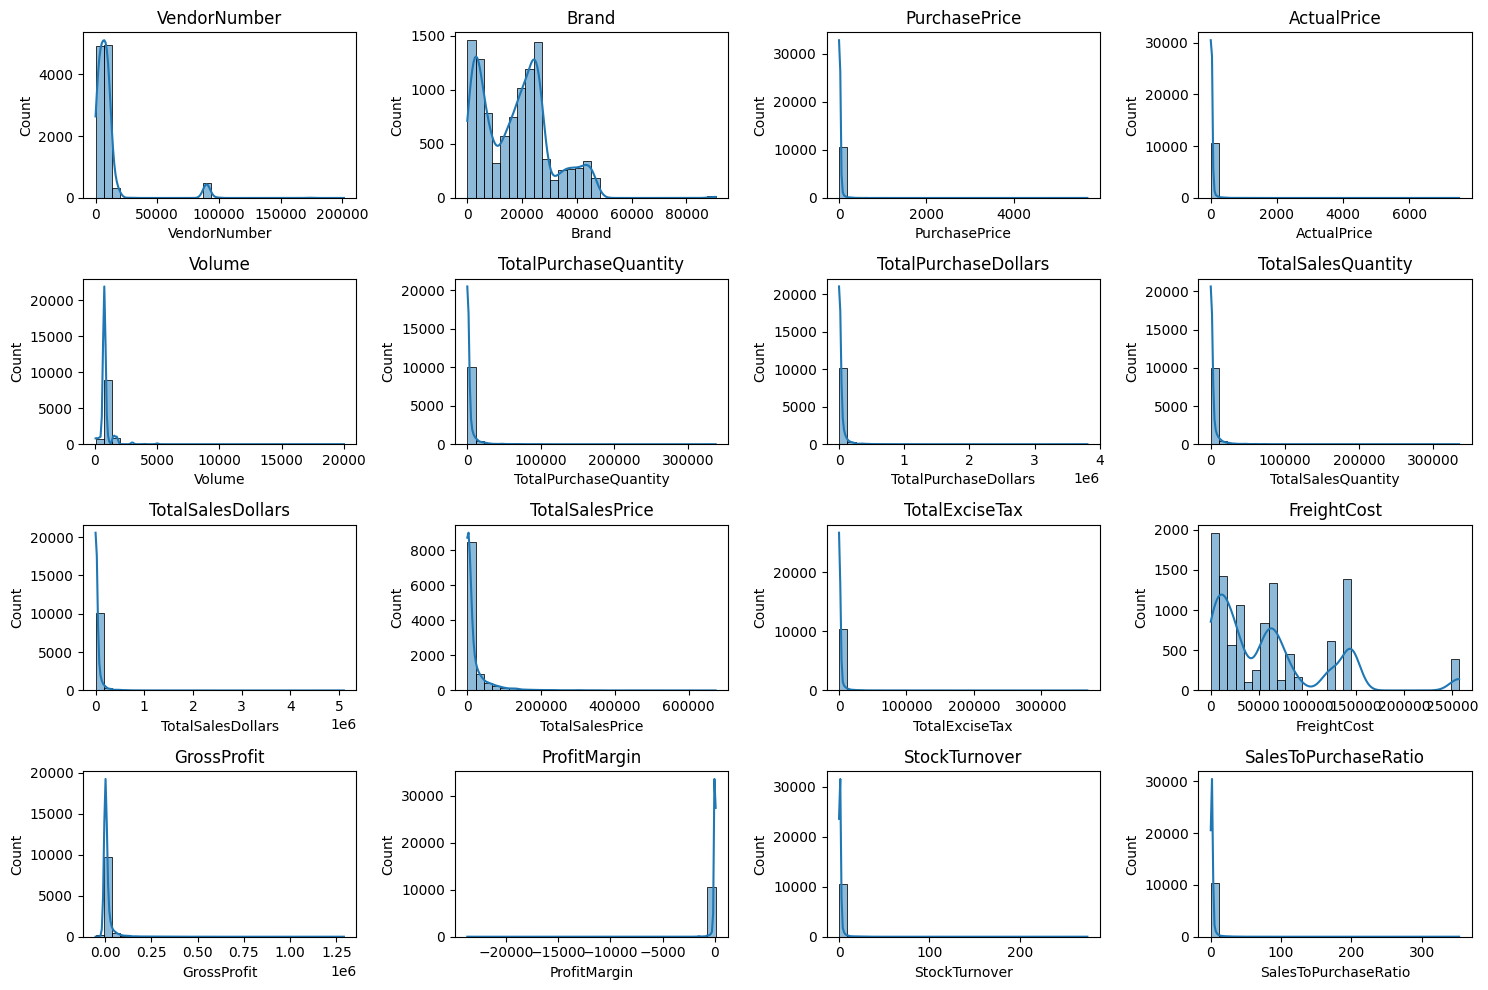

In [6]:
# Distribution Plots for Numerical Columns
numeric_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(4, 4, i + 1) # Adjust grid layout as needed
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)

plt.tight_layout()
plt.show()

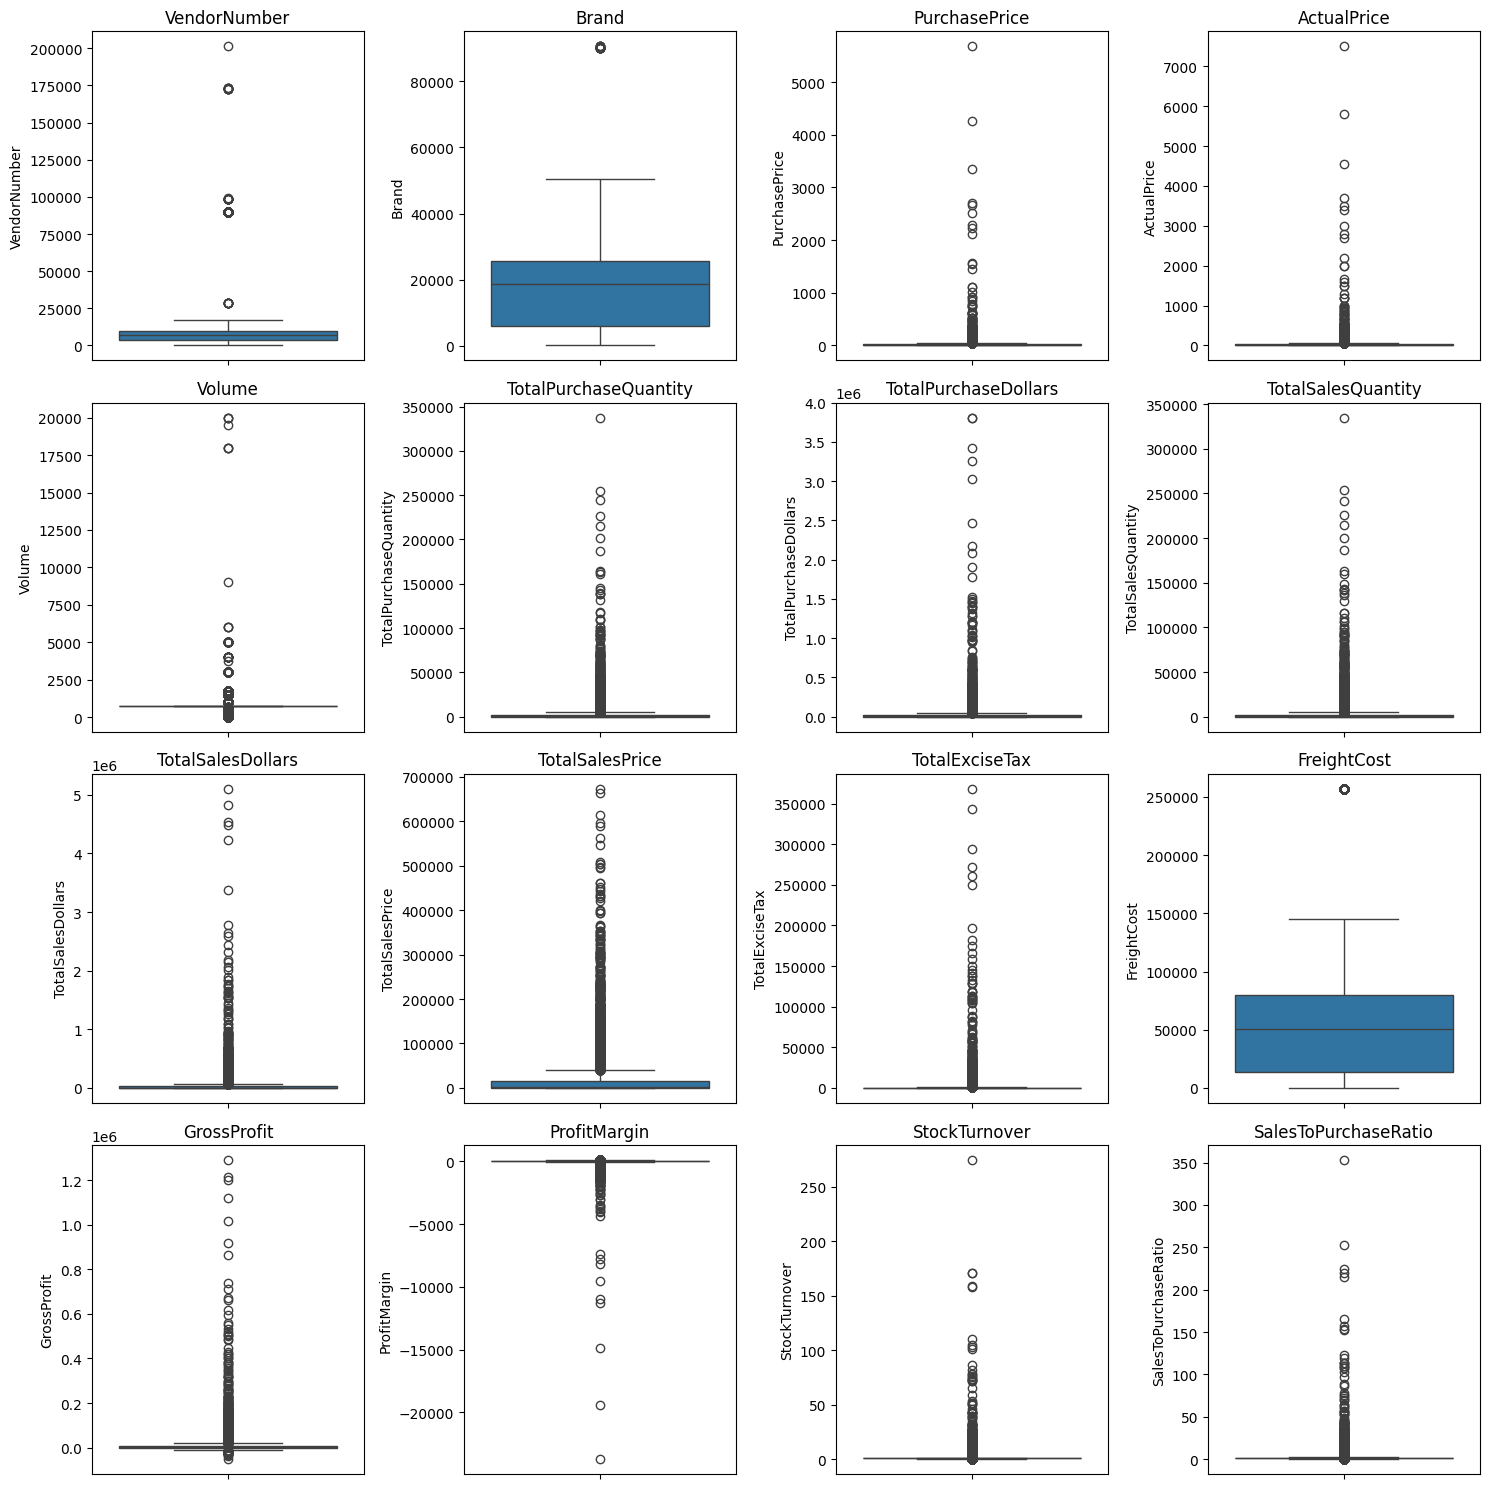

In [7]:
plt.figure(figsize=(15, 15))
for i, col in enumerate(numeric_cols):
    plt.subplot(4, 4, i + 1) # Adjust grid layout as needed
    sns.boxplot(y = df[col])
    plt.title(col)

plt.tight_layout()
plt.show()


<h2>Summary Statistics Insights</h2>

<h3>Negative & Zero Values:</h3>
<ul>
    <li><b>Gross Profit:</b> Minimum value is <b>-52,002.78</b>, indicating some products or transactions may be selling at a loss due to high costs or selling at discounts lower than the purchase price.</li>
    <li><b>Profit Margin:</b> Has a minimum of <b>-&infin;</b>, which suggests cases where revenue is zero or even lower than costs.</li>
    <li><b>Total Sales Quantity & Sales Dollars:</b> Minimum values are <b>0</b>, meaning some products were purchased but never sold. These could be slow-moving or obsolete stock.</li>
</ul>

<h3>Outliers indicated by High Standard Deviations:</h3>
<ul>
    <li><b>Purchase & Actual Prices:</b> The max values (<b>5,681.81 &amp; 7,499.99</b>) are significantly higher than the mean (<b>24.39 &amp; 35.64</b>), indicating potential premium products.</li>
    <li><b>Freight Cost:</b> Huge variation, from <b>0.09 to 257,032.07</b>, suggests logistics inefficiencies or bulk shipments.</li>
    <li><b>Stock Turnover:</b> Ranges from <b>0 to 274.5</b>, implying some products sell extremely fast while others remain in stock indefinitely. Value more than 1 indicates that Sold quantity for that product is higher than purchased quantity due to either sales are being fulfilled from older stock.</li>
</ul>

In [8]:
# let's filter the data by removing inconsistencies
df = pd.read_sql_query("""SELECT *
FROM vendor_sales_summary
WHERE GrossProfit > 0
AND ProfitMargin > 0
AND TotalSalesQuantity > 0""", conn)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorNumber,8564.0,10107.074965,17635.714818,2.00,3664.0000,7153.000,9552.0000,201359.00
Brand,8564.0,17614.670131,12946.130933,58.00,5375.7500,17606.000,24935.2500,90631.00
PurchasePrice,8564.0,21.780897,81.189624,0.36,6.6600,10.060,17.8500,3352.93
ActualPrice,8564.0,32.297467,112.420744,0.49,9.9900,14.990,25.9900,4559.99
Volume,8564.0,864.332321,724.240023,50.00,750.0000,750.000,750.0000,20000.00
TotalPurchaseQuantity,8564.0,3772.008991,12276.960631,1.00,42.0000,431.000,2666.7500,337660.00
TotalPurchaseDollars,8564.0,35887.253324,136722.999153,0.71,546.1875,5018.400,26610.1775,3811251.60
TotalSalesQuantity,8564.0,3748.983419,12125.696083,1.00,62.0000,490.500,2675.0000,334939.00
TotalSalesDollars,8564.0,51542.278077,186071.489729,1.98,1355.5800,8483.780,40622.1125,5101919.51
TotalSalesPrice,8564.0,22759.270732,49305.274018,0.99,584.7900,4549.755,22595.2525,672819.31


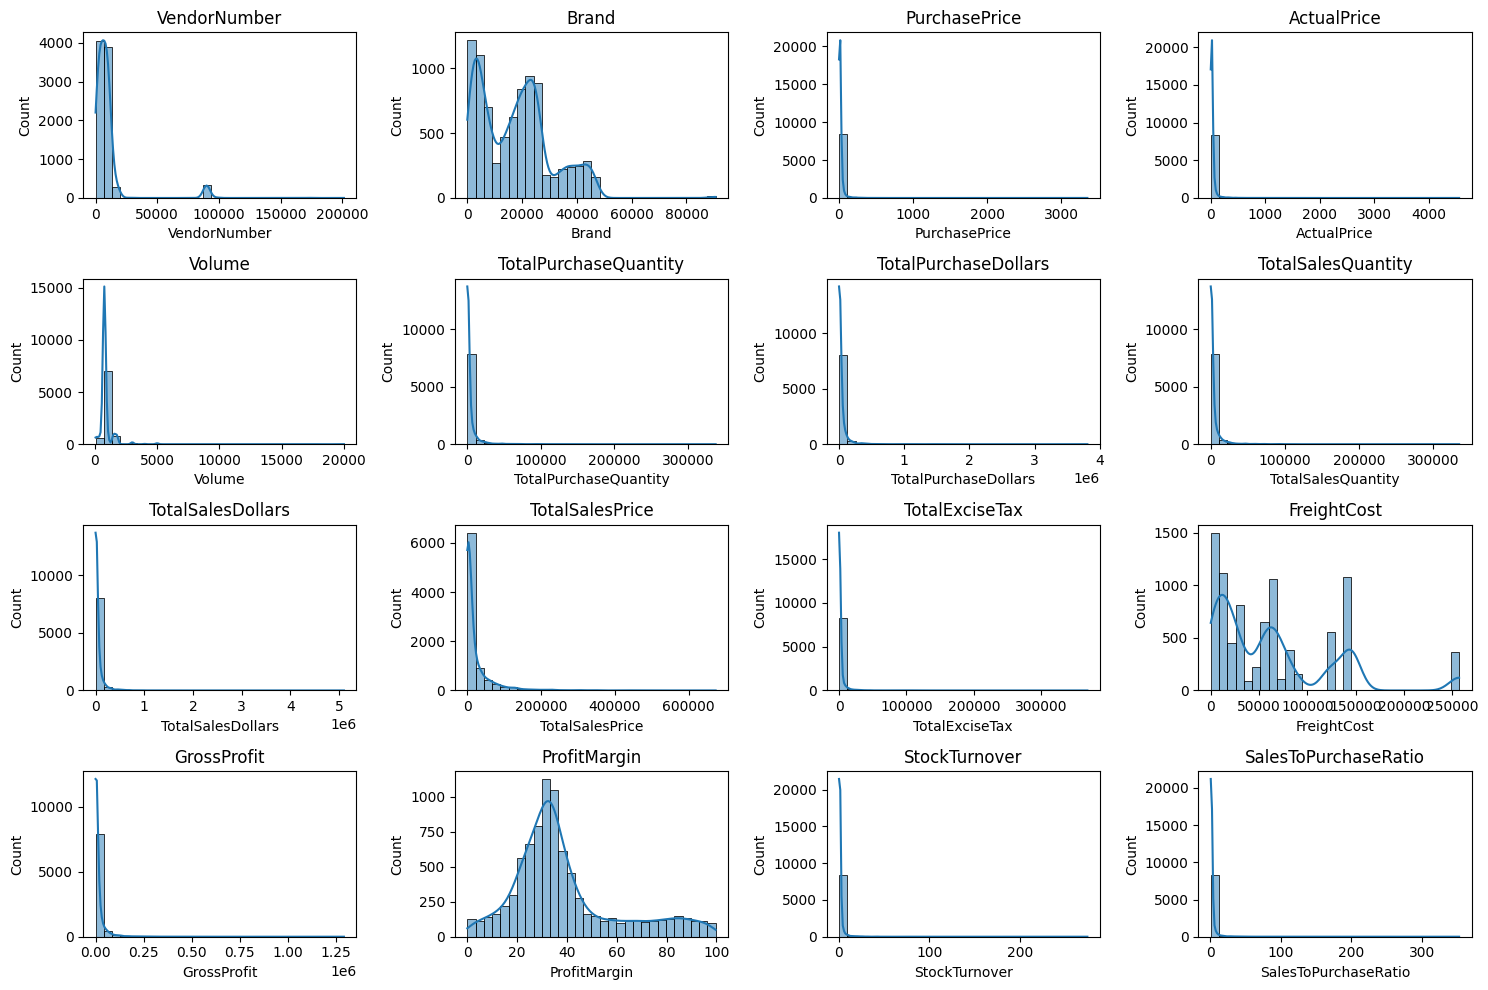

In [10]:
# Distribution Plots for Numerical Columns
numeric_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(4, 4, i + 1) # Adjust grid layout as needed
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)

plt.tight_layout()
plt.show()

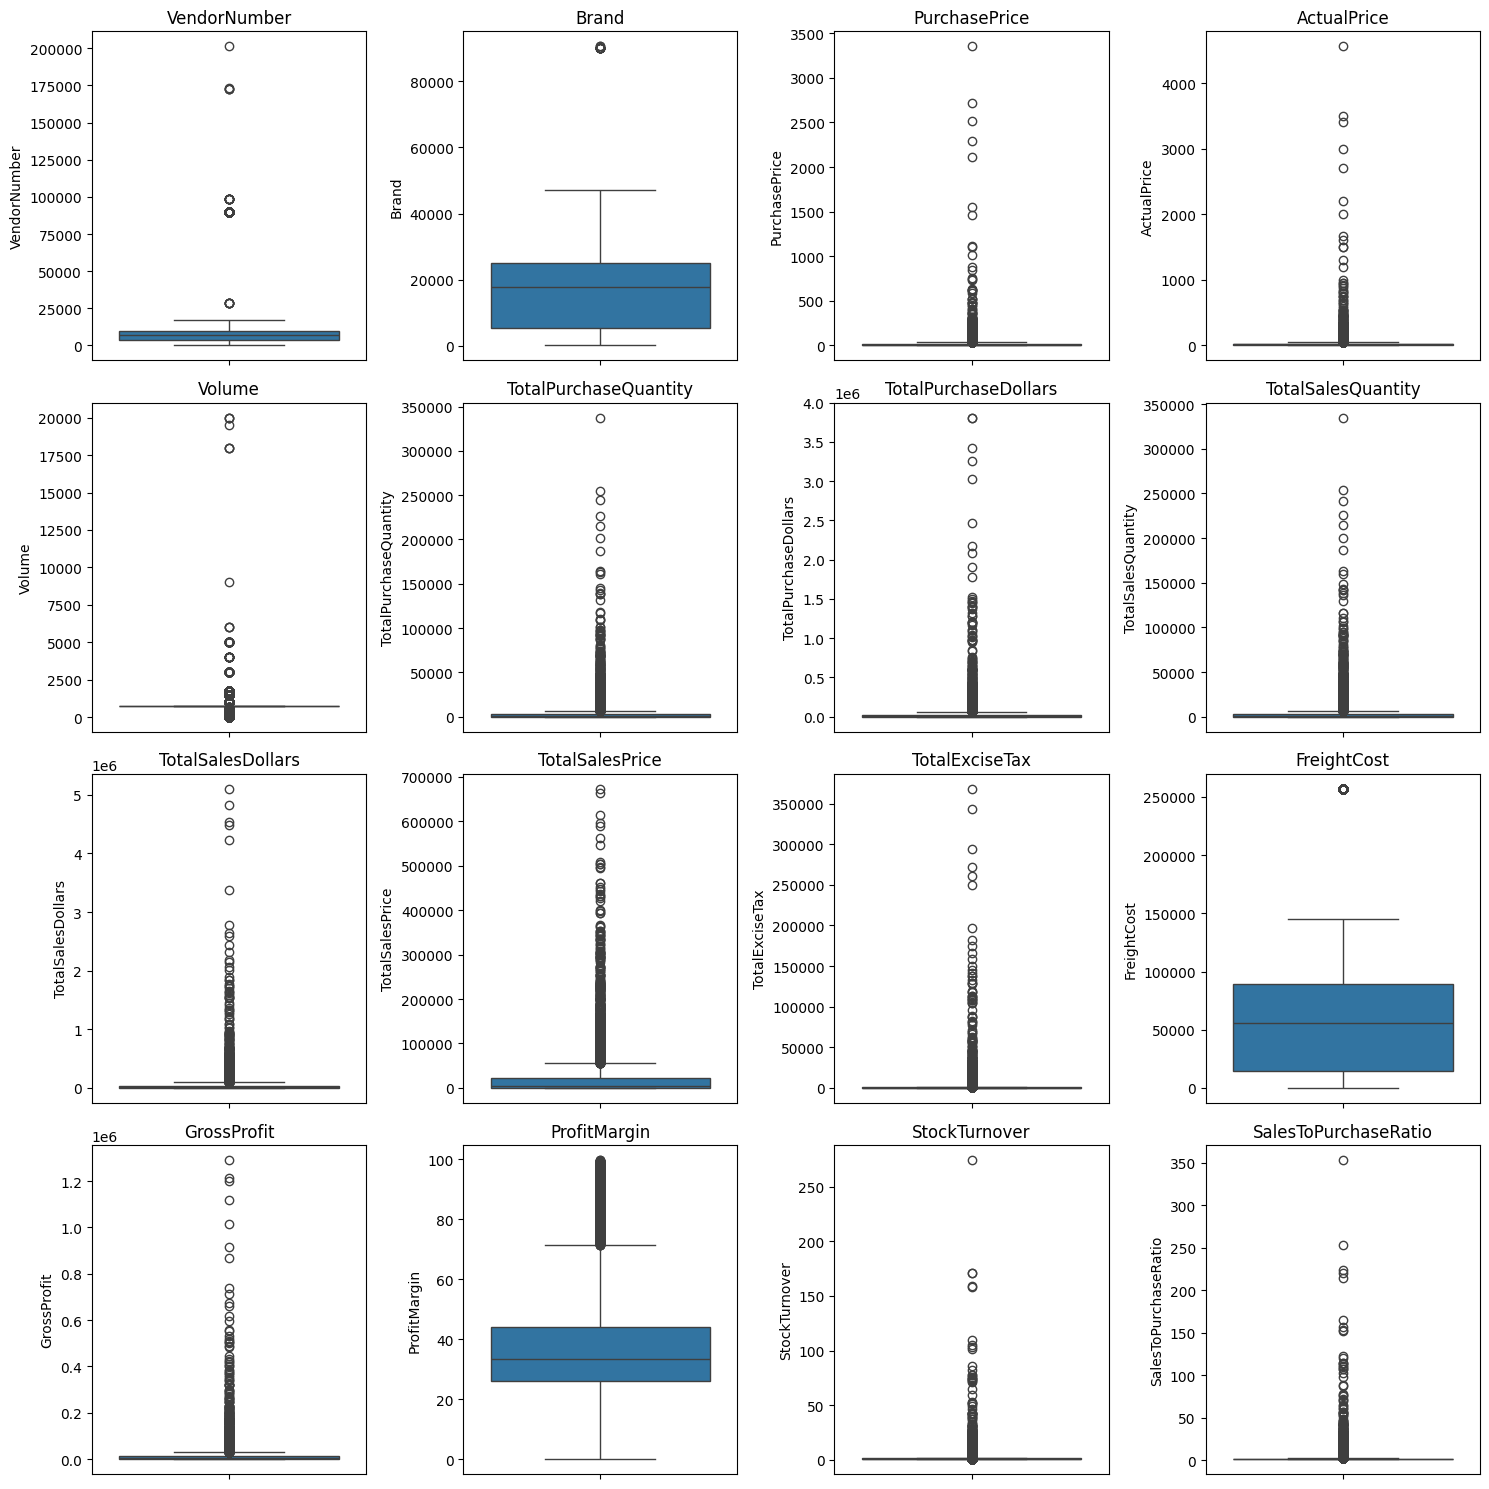

In [11]:
plt.figure(figsize=(15, 15))
for i, col in enumerate(numeric_cols):
    plt.subplot(4, 4, i + 1) # Adjust grid layout as needed
    sns.boxplot(y = df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

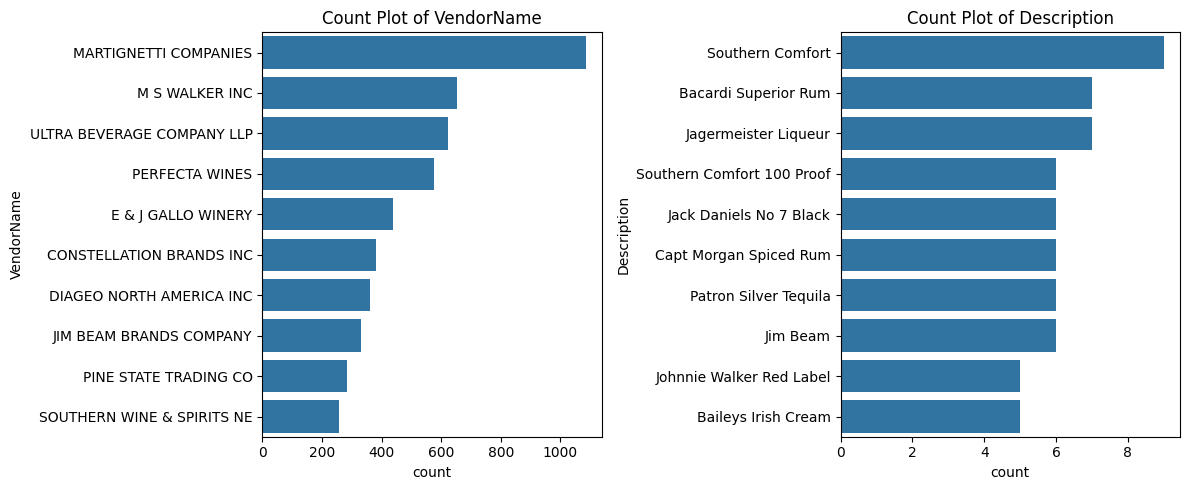

In [12]:
# Count Plots for Categorical Columns
categorical_cols = ["VendorName", "Description"]

plt.figure(figsize=(12, 5))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, 2, i + 1)
    # Filter for the top 10 categories and plot them horizontally (y=col)
    sns.countplot(y=df[col], order=df[col].value_counts().index[:10]) # Top 10 categories
    plt.title(f"Count Plot of {col}")

plt.tight_layout()
plt.show()

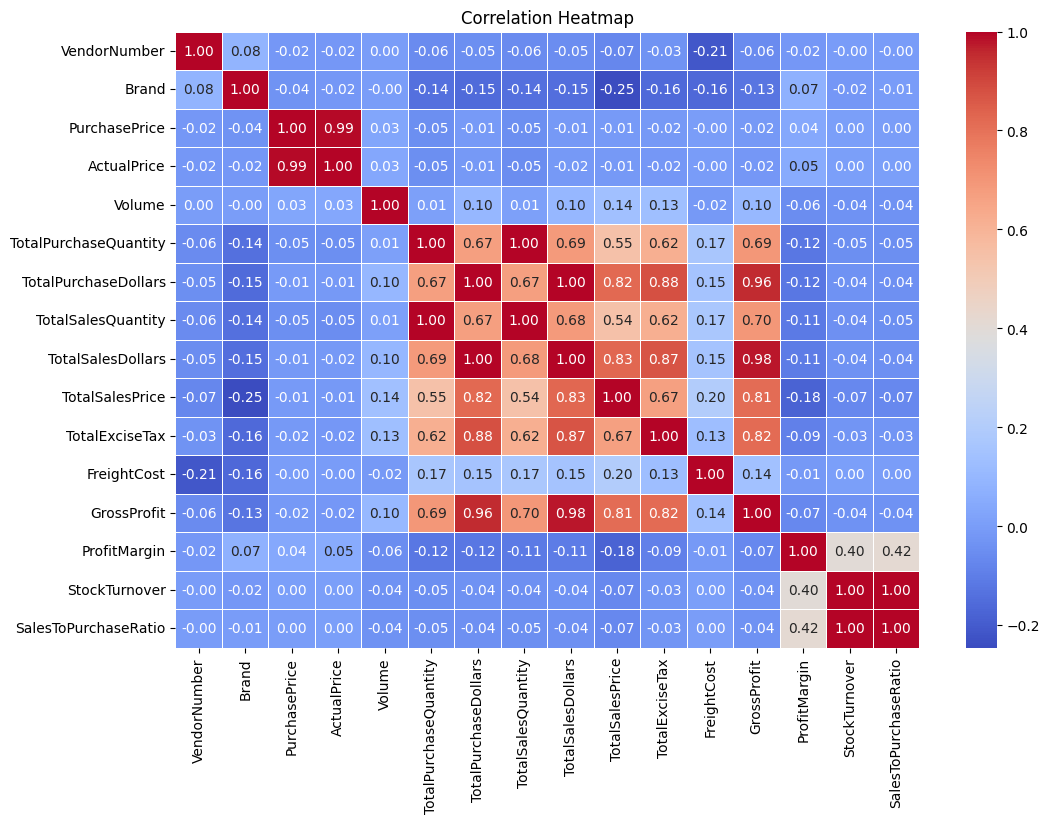

In [13]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
# Note: The image shows df_numerical_cols.corr(), but the variable used in the previous cell was numerical_cols. 
# Assuming a DataFrame (df) is used with its numeric columns only.
correlation_matrix = df.corr(numeric_only=True) 
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

<h2>Correlation Insights</h2>

<ul>
    <li><b>PurchasePrice</b> has <b>weak correlations</b> with TotalSalesDollars (<b>-0.012</b>) and GrossProfit (<b>-0.016</b>), suggesting that price variations do not significantly impact sales revenue or profit.</li>
    <li><b>Strong correlation</b> between total purchase quantity and total sales quantity (<b>0.999</b>), confirming efficient inventory turnover.</li>
    <li><b>Negative correlation</b> between profit margin &amp; total sales price (<b>-0.179</b>) suggests that as sales price increases, margins decrease, possibly due to competitive pricing pressures.</li>
    <li><b>StockTurnover</b> has <b>weak negative correlations</b> with both GrossProfit (<b>-0.038</b>) and ProfitMargin (<b>-0.055</b>), indicating that faster turnover does not necessarily result in higher profitability.</li>
</ul>

<h3>Identify brands that need promotional or pricing adjustment that exhibit lower sales performance but higher profit margin </h3>

In [14]:
brand_performance = df.groupby('Description').agg({
    'TotalSalesDollars': 'sum',
    'ProfitMargin': 'mean'
}).reset_index()

low_sales_threshold = brand_performance['TotalSalesDollars'].quantile(0.15)
high_margin_threshold = brand_performance['ProfitMargin'].quantile(0.85)

print(low_sales_threshold,high_margin_threshold)

560.299 64.96799999999995


In [15]:
brand_performance

,Description,TotalSalesDollars,ProfitMargin
0,(RI) 1,21519.09,18.06
1,.nparalleled Svgn Blanc,1094.63,29.98
2,10 Span Cab Svgn CC,2703.89,20.94
3,10 Span Chard CC,3325.56,27.81
4,10 Span Pnt Gris Monterey Cy,2082.22,32.23
...,...,...,...
7702,Zorvino Vyds Sangiovese,10579.03,29.53
7703,Zuccardi Q Malbec,1639.18,23.98
7704,Zum Rsl,10857.34,32.68
7705,Zwack Liqueur,227.88,16.65


In [16]:
# Filter brands with low sales but high profit margins
target_brands = brand_performance[
    (brand_performance['TotalSalesDollars'] <= low_sales_threshold) & 
    (brand_performance['ProfitMargin'] >= high_margin_threshold)
]

print("Brands with Low Sales but High Profit Margins:")
display(target_brands.sort_values('TotalSalesDollars'))

Brands with Low Sales but High Profit Margins:


,Description,TotalSalesDollars,ProfitMargin
6199,Santa Rita Organic Svgn Bl,9.99,66.47
2369,Debauchery Pnt Nr,11.58,65.98
2070,Concannon Glen Ellen Wh Zin,15.95,83.45
2188,Crown Royal Apple,27.86,89.81
6237,Sauza Sprklg Wild Berry Marg,27.96,82.15
...,...,...,...
5074,Nanbu Bijin Southern Beauty,535.68,76.75
2271,Dad's Hat Rye Whiskey,538.89,81.85
57,A Bichot Clos Marechaudes,539.94,67.74
6245,Sbragia Home Ranch Merlot,549.75,66.44


In [17]:
brand_performance = brand_performance[brand_performance['TotalSalesDollars']<10000]# for better viz

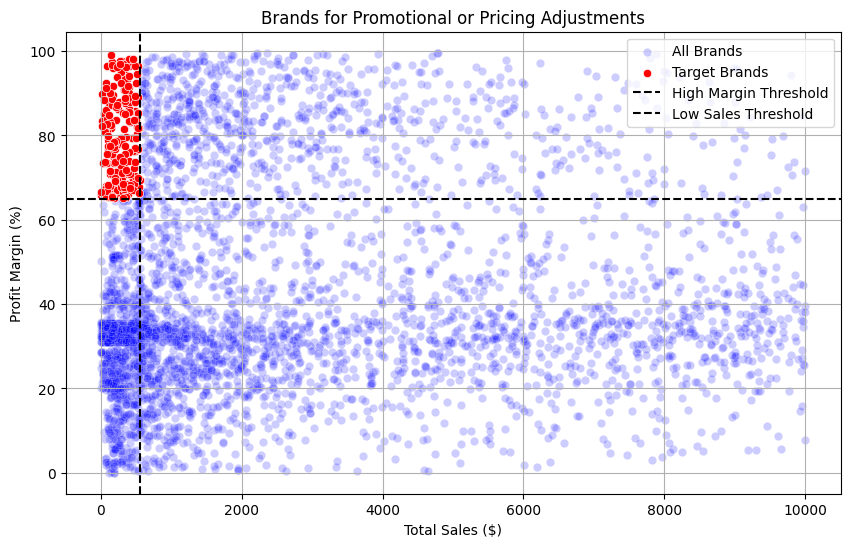

In [18]:
plt.figure(figsize=(10, 6))

# Plot all brands
sns.scatterplot(data=brand_performance, x='TotalSalesDollars', y='ProfitMargin', color="blue", label="All Brands", alpha=0.2)

# Plot the target brands (Low Sales, High Margin)
sns.scatterplot(data=target_brands, x='TotalSalesDollars', y='ProfitMargin', color="red", label="Target Brands")

# Add horizontal line for the high profit margin threshold
plt.axhline(high_margin_threshold, linestyle='--', color='black', label="High Margin Threshold")

# Add vertical line for the low sales threshold
plt.axvline(low_sales_threshold, linestyle='--', color='black', label="Low Sales Threshold")

# Set labels and title
plt.xlabel("Total Sales ($)")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for Promotional or Pricing Adjustments")

# Final plot commands
plt.legend()
plt.grid(True)
plt.show()

In [19]:
def format_dollars(value):
    if value >= 1_000_000:
        return f"${value / 1_000_000:.2f}M"
    elif value >= 1_000:
        return f"${value / 1_000:.2f}K"
    else:
        return str(value)

In [20]:
# Top Vendors & Brands by Sales Performance
top_vendors = df.groupby("VendorName")["TotalSalesDollars"].sum().nlargest(10)
top_brands = df.groupby("Description")["TotalSalesDollars"].sum().nlargest(10)

top_brands.apply(lambda x : format_dollars(x))

Description
Jack Daniels No 7 Black    $7.96M
Tito's Handmade Vodka      $7.40M
Grey Goose Vodka           $7.21M
Capt Morgan Spiced Rum     $6.36M
Absolut 80 Proof           $6.24M
Jameson Irish Whiskey      $5.72M
Ketel One Vodka            $5.07M
Baileys Irish Cream        $4.15M
Kahlua                     $3.60M
Tanqueray                  $3.46M
Name: TotalSalesDollars, dtype: object

In [21]:
top_vendors.apply(lambda x : format_dollars(x))

VendorName
DIAGEO NORTH AMERICA INC      $67.99M
MARTIGNETTI COMPANIES         $39.33M
PERNOD RICARD USA             $32.06M
JIM BEAM BRANDS COMPANY       $31.42M
BACARDI USA INC               $24.85M
CONSTELLATION BRANDS INC      $24.22M
E & J GALLO WINERY            $18.40M
BROWN-FORMAN CORP             $18.25M
ULTRA BEVERAGE COMPANY LLP    $16.50M
M S WALKER INC                $14.71M
Name: TotalSalesDollars, dtype: object

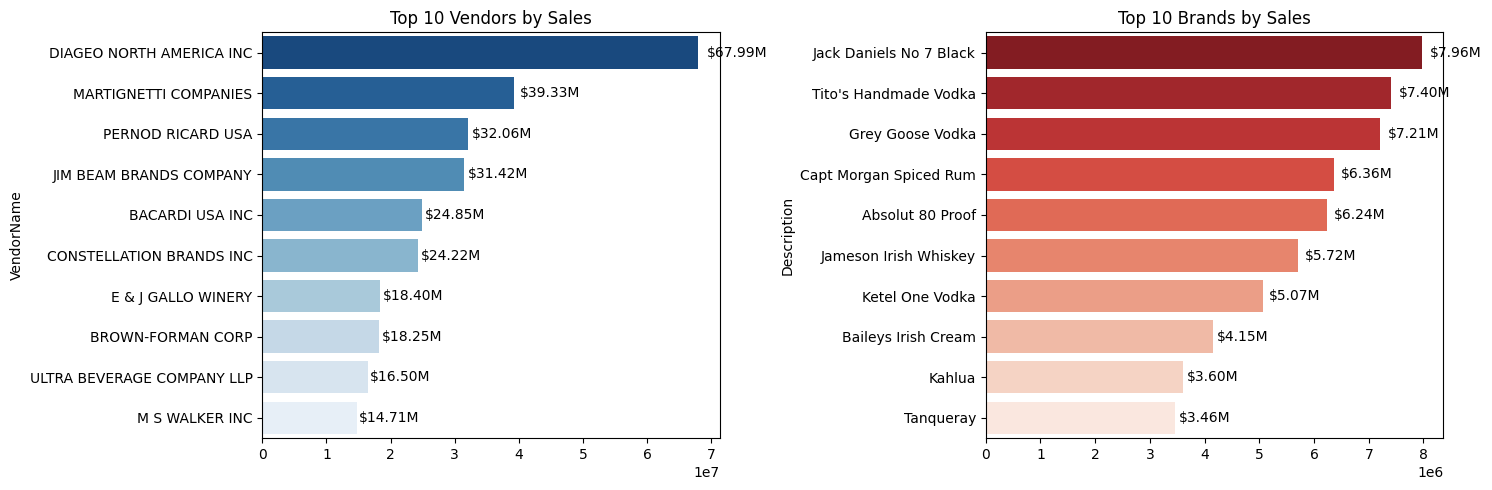

In [22]:
plt.figure(figsize=(15, 5))

# Plot for Top Vendors
plt.subplot(1, 2, 1)
ax1 = sns.barplot(y=top_vendors.index, x=top_vendors.values, palette="Blues_r")
plt.title("Top 10 Vendors by Sales")

# Add data labels for Top Vendors
for bar in ax1.patches:
    ax1.text(bar.get_width() + (bar.get_width() * 0.02),
             bar.get_y() + bar.get_height() / 2,
             format_dollars(bar.get_width()),
             ha='left', va='center', fontsize=10, color='black')

# Plot for Top Brands
plt.subplot(1, 2, 2)
# Ensure index is treated as string for categorical plotting
ax2 = sns.barplot(y=top_brands.index.astype(str), x=top_brands.values, palette="Reds_r")
plt.title("Top 10 Brands by Sales")

# Add data labels for Top Brands
for bar in ax2.patches:
    ax2.text(bar.get_width() + (bar.get_width() * 0.02),
             bar.get_y() + bar.get_height() / 2,
             format_dollars(bar.get_width()),
             ha='left', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

In [23]:
vendor_performance = df.groupby('VendorName').agg({
    'TotalPurchaseDollars': 'sum',
    'GrossProfit': 'sum',
    'TotalSalesDollars': 'sum'
}).reset_index()

# Corrected calculation: Vendor's Purchase Dollars / Total Purchase Dollars (across all vendors)
total_purchase_sum = vendor_performance['TotalPurchaseDollars'].sum()
vendor_performance['PurchaseContribution%'] = (vendor_performance['TotalPurchaseDollars'] / total_purchase_sum) * 100

In [24]:
vendor_performance = round(vendor_performance.sort_values("PurchaseContribution%", ascending  = False),2)

In [25]:
top_vendors = vendor_performance.head(10)
top_vendors['TotalSalesDollars'] = top_vendors['TotalSalesDollars'].apply(format_dollars)
top_vendors['TotalPurchaseDollars'] = top_vendors['TotalPurchaseDollars'].apply(format_dollars)
top_vendors['GrossProfit'] = top_vendors['GrossProfit'].apply(format_dollars)

top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution%
25,DIAGEO NORTH AMERICA INC,$50.10M,$17.89M,$67.99M,16.30
57,MARTIGNETTI COMPANIES,$25.50M,$13.83M,$39.33M,8.30
68,PERNOD RICARD USA,$23.85M,$8.21M,$32.06M,7.76
46,JIM BEAM BRANDS COMPANY,$23.49M,$7.93M,$31.42M,7.64
6,BACARDI USA INC,$17.43M,$7.42M,$24.85M,5.67
20,CONSTELLATION BRANDS INC,$15.27M,$8.95M,$24.22M,4.97
11,BROWN-FORMAN CORP,$13.24M,$5.01M,$18.25M,4.31
30,E & J GALLO WINERY,$12.07M,$6.33M,$18.40M,3.93
106,ULTRA BEVERAGE COMPANY LLP,$11.17M,$5.34M,$16.50M,3.63
53,M S WALKER INC,$9.76M,$4.94M,$14.71M,3.18


In [26]:
top_vendors['Cumulative_Contribution%'] = top_vendors['PurchaseContribution%'].cumsum()
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution%,Cumulative_Contribution%
25,DIAGEO NORTH AMERICA INC,$50.10M,$17.89M,$67.99M,16.30,16.30
57,MARTIGNETTI COMPANIES,$25.50M,$13.83M,$39.33M,8.30,24.60
68,PERNOD RICARD USA,$23.85M,$8.21M,$32.06M,7.76,32.36
46,JIM BEAM BRANDS COMPANY,$23.49M,$7.93M,$31.42M,7.64,40.00
6,BACARDI USA INC,$17.43M,$7.42M,$24.85M,5.67,45.67
20,CONSTELLATION BRANDS INC,$15.27M,$8.95M,$24.22M,4.97,50.64
11,BROWN-FORMAN CORP,$13.24M,$5.01M,$18.25M,4.31,54.95
30,E & J GALLO WINERY,$12.07M,$6.33M,$18.40M,3.93,58.88
106,ULTRA BEVERAGE COMPANY LLP,$11.17M,$5.34M,$16.50M,3.63,62.51
53,M S WALKER INC,$9.76M,$4.94M,$14.71M,3.18,65.69


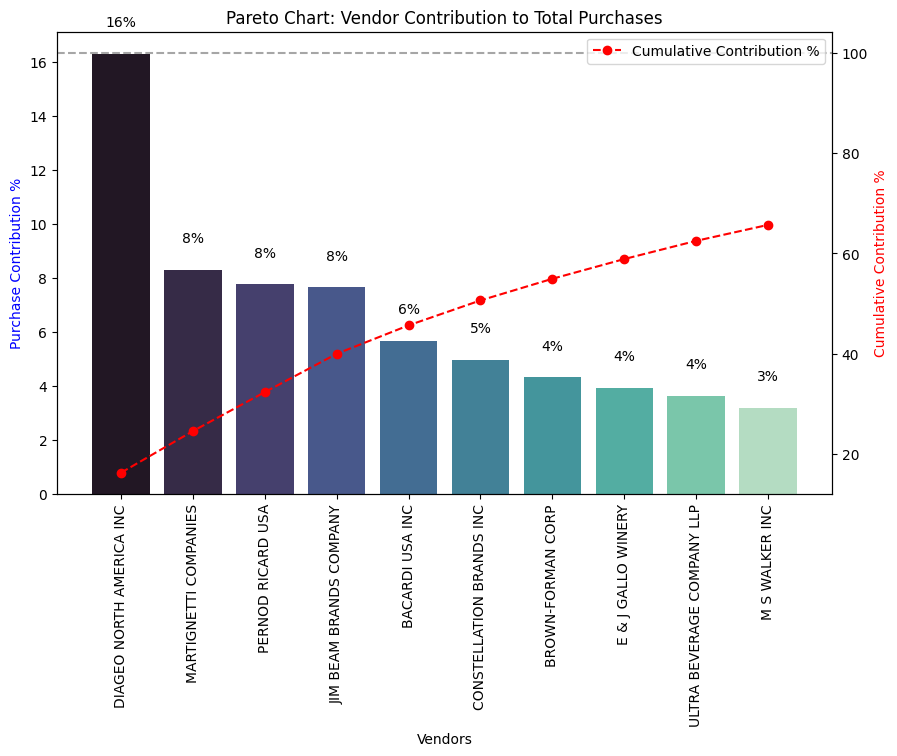

In [27]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for Purchase Contribution %
# CORRECTED: Changed 'Purchase_Contribution%' to 'PurchaseContribution%'
sns.barplot(x='VendorName', y='PurchaseContribution%', data=top_vendors, palette="mako", ax=ax1)

# Add data labels to bars
# CORRECTED: Changed 'Purchase_Contribution%' to 'PurchaseContribution%'
for i, value in enumerate(top_vendors['PurchaseContribution%']):
    # Place text slightly above the bar
    ax1.text(i, value + 1, str(round(value)) + '%', ha='center', fontsize=10, color='black')

# Create a secondary axis for the cumulative line
ax2 = ax1.twinx()

# Line Plot for Cumulative Contribution % (Assuming this column is correct)
ax2.plot(top_vendors['VendorName'], top_vendors['Cumulative_Contribution%'], color='red', marker='o', linestyle='dashed', label='Cumulative Contribution %')

# Customization for ax1 (Bar chart)
ax1.set_xticklabels(top_vendors['VendorName'], rotation=90)
ax1.set_ylabel('Purchase Contribution %', color='blue')
ax1.set_xlabel('Vendors')
ax1.set_title('Pareto Chart: Vendor Contribution to Total Purchases')

# Customization for ax2 (Line chart)
ax2.set_ylabel('Cumulative Contribution %', color='red')
ax2.axhline(y=100, color='gray', linestyle='dashed', alpha=0.7)
ax2.legend(loc='upper right')

plt.show()

<h3>How muchh total pocrumnet is dependent on top vendors</h3>

Total Purchase Contribution of top 10 vendors is 65.69 %


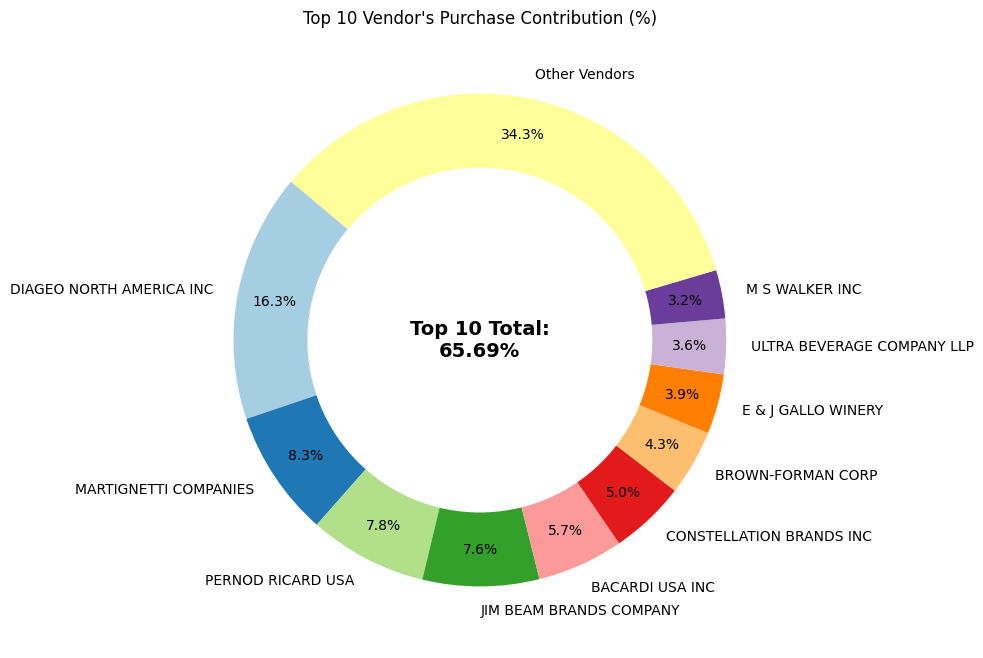

In [28]:
print(f"Total Purchase Contribution of top 10 vendors is {round(top_vendors['PurchaseContribution%'].sum(), 2)} %")

vendors = list(top_vendors['VendorName'].values)
purchase_contributions = list(top_vendors['PurchaseContribution%'].values)
total_contribution = sum(purchase_contributions)
remaining_contribution = 100 - total_contribution

# Append "Other Vendors" category
vendors.append("Other Vendors")
purchase_contributions.append(remaining_contribution)

# Donut Chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    purchase_contributions, 
    labels=vendors, 
    autopct='%1.1f%%', 
    startangle=140, 
    pctdistance=0.85, 
    colors=plt.cm.Paired.colors
)

# Draw a white circle in the center to create a "donut" effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Add Total Contribution annotation in the center
plt.text(
    0, 0, 
    f"Top 10 Total:\n{total_contribution:.2f}%", 
    fontsize=14, 
    fontweight='bold', 
    ha='center', 
    va='center'
)

plt.title("Top 10 Vendor's Purchase Contribution (%)")
plt.show()

<h2> does ordering in bulk reduce unit price and what is optimla purcasing volume</h2>

In [29]:
df['UnitPurchasePrice'] = df['TotalPurchaseDollars'] / df['TotalPurchaseQuantity']

In [30]:
df['OrderSize'] = pd.qcut(df['TotalPurchaseQuantity'], q=3, labels=["Small", "Medium", "Large"])

In [31]:
df[['TotalPurchaseQuantity','OrderSize']]

,TotalPurchaseQuantity,OrderSize
0,8,Small
1,39,Small
2,12,Small
3,320,Medium
4,96,Medium
...,...,...
8559,138,Medium
8560,267,Medium
8561,554,Medium
8562,1232,Medium


In [32]:
df.groupby('OrderSize')[['UnitPurchasePrice']].mean()

,UnitPurchasePrice
OrderSize,
Small,39.068186
Medium,15.486414
Large,10.777625


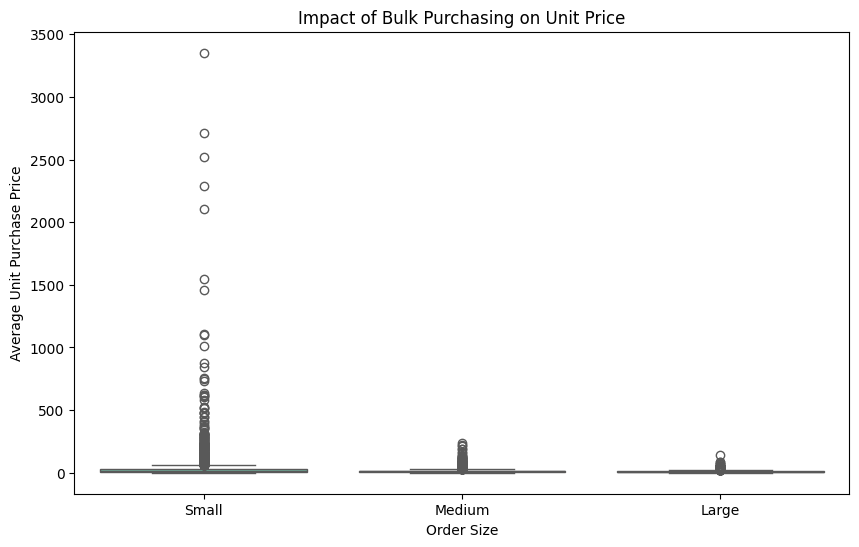

In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="OrderSize", y="UnitPurchasePrice", palette="Set2")
plt.title("Impact of Bulk Purchasing on Unit Price")
plt.xlabel("Order Size")
plt.ylabel("Average Unit Purchase Price")
plt.show()

In [34]:
df.columns

Index(['VendorNumber', 'VendorName', 'Brand', 'Description', 'PurchasePrice',
       'ActualPrice', 'Volume', 'TotalPurchaseQuantity',
       'TotalPurchaseDollars', 'TotalSalesQuantity', 'TotalSalesDollars',
       'TotalSalesPrice', 'TotalExciseTax', 'FreightCost', 'GrossProfit',
       'ProfitMargin', 'StockTurnover', 'SalesToPurchaseRatio',
       'UnitPurchasePrice', 'OrderSize'],
      dtype='object')

<h2>which vendors have low inventory turn over , indicating excess stock and slow moving products</h2>

In [35]:
df[df["StockTurnover"]<1].groupby('VendorName')[['StockTurnover']].mean().sort_values('StockTurnover', ascending = True).head(10)

,StockTurnover
VendorName,
ALISA CARR BEVERAGES,0.620000
HIGHLAND WINE MERCHANTS LLC,0.710000
PARK STREET IMPORTS LLC,0.750000
Circa Wines,0.755385
KLIN SPIRITS LLC,0.760000
Dunn Wine Brokers,0.767500
CENTEUR IMPORTS LLC,0.772500
SMOKY QUARTZ DISTILLERY LLC,0.780000
TAMWORTH DISTILLING,0.800000


<h2>HOw much capital is locked in unsold inventory per vendor, and which vendors contribute the most?</h2>

In [36]:
df['UnsoldInventoryValue'] = (df["TotalPurchaseQuantity"] - df["TotalSalesQuantity"]) * df["PurchasePrice"]
print('Total Unsold Capital:', format_dollars(df['UnsoldInventoryValue'].sum()))

# Aggregate Capital Locked per Vendor
inventory_value_per_vendor = df.groupby("VendorName")["UnsoldInventoryValue"].sum().reset_index()

# Sort Vendors with the Highest Locked Capital
inventory_value_per_vendor = inventory_value_per_vendor.sort_values(by="UnsoldInventoryValue", ascending=False)
inventory_value_per_vendor['UnsoldInventoryValue'] = inventory_value_per_vendor['UnsoldInventoryValue'].apply(format_dollars)
inventory_value_per_vendor.head(10)

Total Unsold Capital: $2.71M


,VendorName,UnsoldInventoryValue
25,DIAGEO NORTH AMERICA INC,$722.21K
46,JIM BEAM BRANDS COMPANY,$554.67K
68,PERNOD RICARD USA,$470.63K
116,WILLIAM GRANT & SONS INC,$401.96K
30,E & J GALLO WINERY,$228.28K
79,SAZERAC CO INC,$198.44K
11,BROWN-FORMAN CORP,$177.73K
20,CONSTELLATION BRANDS INC,$133.62K
61,MOET HENNESSY USA INC,$126.48K
77,REMY COINTREAU USA INC,$118.60K


<h2>what is 95% confidence intervalsfor profit margins of top performing vendors and low performing vendors</h2>

In [37]:
top_threshold = df["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)

top_vendors = df[df["TotalSalesDollars"] >= top_threshold]["ProfitMargin"].dropna()
low_vendors = df[df["TotalSalesDollars"] <= low_threshold]["ProfitMargin"].dropna()

In [38]:
def confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data)
    # Calculate Standard Error (ddof=1 for sample standard deviation)
    std_err = np.std(data, ddof=1) / np.sqrt(len(data)) 
    
    # Calculate the critical t-score using the Percent Point Function (ppf)
    t_critical = stats.t.ppf((1 + confidence) / 2, df=len(data) - 1)
    
    # Calculate the Margin of Error
    margin_of_error = t_critical * std_err
    
    # Return the mean, lower bound, and upper bound of the confidence interval
    return mean_val, mean_val - margin_of_error, mean_val + margin_of_error

Top Vendors 95% CI: [30.74, 31.61], Mean: 31.18
Low Vendors 95% CI: [40.50, 42.64], Mean: 41.57


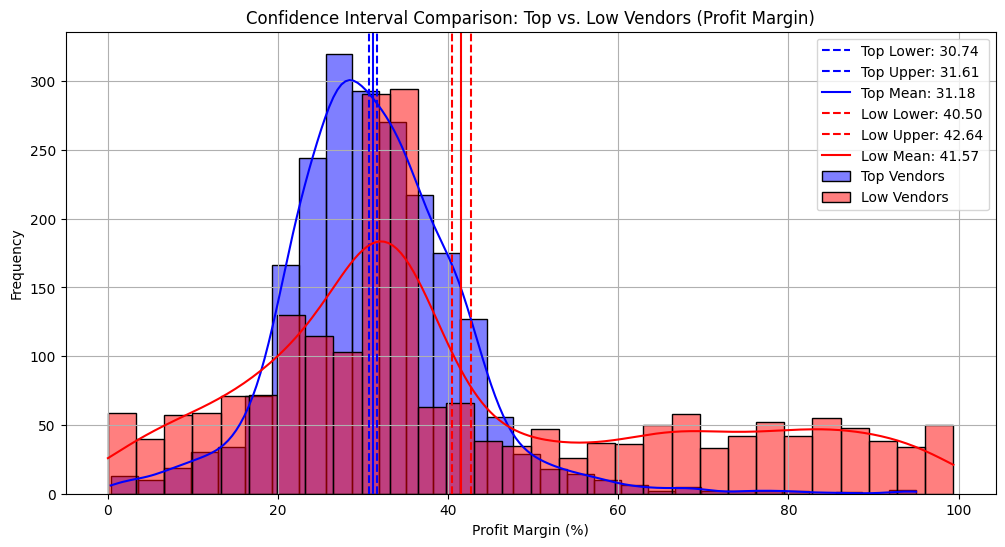

In [39]:
# Calculate Confidence Intervals
top_mean, top_lower, top_upper = confidence_interval(top_vendors)
low_mean, low_lower, low_upper = confidence_interval(low_vendors)

# Print Results
print(f"Top Vendors 95% CI: [{top_lower:.2f}, {top_upper:.2f}], Mean: {top_mean:.2f}")
print(f"Low Vendors 95% CI: [{low_lower:.2f}, {low_upper:.2f}], Mean: {low_mean:.2f}")

# Start Plotting
plt.figure(figsize=(12, 6))

# Top Vendors Plot (Blue)
# Histogram/KDE
sns.histplot(top_vendors, kde=True, color="blue", bins=30, alpha=0.5, label="Top Vendors")
# Confidence Interval Bounds and Mean Line
plt.axvline(top_lower, color="blue", linestyle="--", label=f"Top Lower: {top_lower:.2f}")
plt.axvline(top_upper, color="blue", linestyle="--", label=f"Top Upper: {top_upper:.2f}")
plt.axvline(top_mean, color="blue", linestyle="-", label=f"Top Mean: {top_mean:.2f}")

# Low Vendors Plot (Red)
# Histogram/KDE
sns.histplot(low_vendors, kde=True, color="red", bins=30, alpha=0.5, label="Low Vendors")
# Confidence Interval Bounds and Mean Line
plt.axvline(low_lower, color="red", linestyle="--", label=f"Low Lower: {low_lower:.2f}")
plt.axvline(low_upper, color="red", linestyle="--", label=f"Low Upper: {low_upper:.2f}")
plt.axvline(low_mean, color="red", linestyle="-", label=f"Low Mean: {low_mean:.2f}")

# Finalize Plot
plt.title("Confidence Interval Comparison: Top vs. Low Vendors (Profit Margin)")
plt.xlabel("Profit Margin (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

<ul>
    <li>The confidence interval for low-performing vendors (<b>40.48% to 42.62%</b>) is <b>significantly higher</b> than that of top-performing vendors (<b>30.74% to 31.61%</b>).</li>
    <li>This suggests that vendors with lower sales tend to maintain <b>higher profit margins</b>, potentially due to premium pricing or lower operational costs.</li>
    <li>For <b>High-Performing Vendors</b>: If they aim to improve profitability, they could explore selective price adjustments, cost optimization, or bundling strategies.</li>
    <li>For <b>Low-Performing Vendors</b>: Despite higher margins, their low sales volume might indicate a need for better marketing, competitive pricing, or improved distribution strategies.</li>
</ul>

<h3>Is there a significant difference in profit margins between top-performing and low-performing vendors?</h3>

<h4>Hypothesis:</h4>
<ul>
    <li>H₀ (Null Hypothesis): There is <b>no significant difference</b> in the mean profit margins of top-performing and low-performing vendors.</li>
    <li>H₁ (Alternative Hypothesis): The mean profit margins of top-performing and low-performing vendors are <b>significantly different</b>.</li>
</ul>

In [40]:
# Calculate Sales Thresholds (Quantiles)
top_threshold = df["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)

# Filter Profit Margins for Top and Low Sales Groups
# NOTE: top_vendors and low_vendors are Pandas Series containing profit margins
top_vendors = df[df["TotalSalesDollars"] >= top_threshold]["ProfitMargin"].dropna()
low_vendors = df[df["TotalSalesDollars"] <= low_threshold]["ProfitMargin"].dropna()

# Perform Two-Sample T-Test
# equal_var=False performs Welch's t-test, which does not assume equal population variances.
t_stat, p_value = ttest_ind(top_vendors, low_vendors, equal_var=False)

# Print results
print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject H₀: There is a significant difference in profit margins between top and low-performing vendors.")
else:
    print("Fail to Reject H₀: No significant difference in profit margins.")

T-Statistic: -17.6693, P-Value: 0.0000
Reject H₀: There is a significant difference in profit margins between top and low-performing vendors.


In [43]:
df.to_csv('vendor_sales_summary.xlsx')

In [45]:
!pip install openpyxl



   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpy

In [47]:
df.to_excel('vendor_sales_summary.xlsx')